<a href="https://colab.research.google.com/github/izzyolejnik/Machine-Learning/blob/master/HW4/HW4PT3DenseNet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning DenseNet


This is an extension of Proffesor Wocjan's VGG16 finetuning notebook to use DenseNet instead.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the Densenet model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 22:30:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  92.9MB/s    in 0.7s    

2020-04-21 22:30:51 (92.9 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with DenseNet convolution base and custom densely connected layers



### Load the convolutional base

In [4]:
from keras.applications import densenet

conv_base = densenet.DenseNet121(input_shape=(224, 224, 3),
                                 weights='imagenet', 
                                 include_top=False)

Using TensorFlow backend.


29089792/29084464 [==============================] - 2s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
for lay in conv_base.layers:
  print(lay.name)

input_1
zero_padding2d_1
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_2
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               12845312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 19,883,073
Trainable params: 12,845,569
Non-trainable params: 7,037,504
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 47s 474ms/step - loss: 0.3619 - acc: 0.8485 - val_loss: 0.0088 - val_acc: 0.9570
Epoch 2/30
100/100 [==============================] - 31s 311ms/step - loss: 0.1912 - acc: 0.9275 - val_loss: 0.0199 - val_acc: 0.9770
Epoch 3/30
100/100 [==============================] - 32s 317ms/step - loss: 0.1350 - acc: 0.9480 - val_loss: 0.0403 - val_acc: 0.9250
Epoch 4/30
100/100 [==============================] - 31s 314ms/step - loss: 0.1447 - acc: 0.9415 - val_loss: 0.1848 - val_acc: 0.9110
Epoch 5/30
100/100 [==============================] - 31s 311ms/step - loss: 0.1200 - acc: 0.9580 - val_loss: 0.2249 - val_acc: 0.9510
Epoch 6/30
100/100 [==============================] - 31s 313ms/step - loss: 0.1223 - acc: 0.9540 - val_loss: 0.0281 - val_acc: 0.9670
Epoch 7/30
100/100 [==============================] - 32s 317ms/step - loss: 0.1106 - acc: 0.9555 - val_lo

## Display curves of loss and accuracy during training

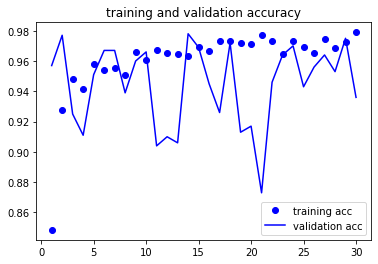

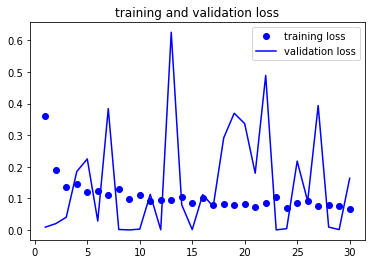

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv5_block1_0_bn':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [17]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/50
100/100 [==============================] - 50s 499ms/step - loss: 0.0167 - acc: 0.9935 - val_loss: 1.1664e-08 - val_acc: 0.9800
Epoch 2/50
100/100 [==============================] - 32s 321ms/step - loss: 0.0115 - acc: 0.9965 - val_loss: 3.6751e-04 - val_acc: 0.9870
Epoch 3/50
100/100 [==============================] - 33s 328ms/step - loss: 0.0195 - acc: 0.9945 - val_loss: 9.0908e-04 - val_acc: 0.9870
Epoch 4/50
100/100 [==============================] - 33s 330ms/step - loss: 0.0150 - acc: 0.9955 - val_loss: 0.2459 - val_acc: 0.9870
Epoch 5/50
100/100 [==============================] - 33s 327ms/step - loss: 0.0214 - acc: 0.9930 - val_loss: 1.8739e-04 - val_acc: 0.9880
Epoch 6/50
100/100 [==============================] - 33s 325ms/step - loss: 0.0126 - acc: 0.9955 - val_loss: 2.8080e-07 - val_acc: 0.9850
Epoch 7/50
100/100 [==============================] - 33s 331ms/step - loss: 0.0151 - acc: 0.9950 - val_loss: 1.1747e-05 - val_acc: 0.9860
Epoch 8/50
100/100 [===========

## Display learning curves during fine-tuning

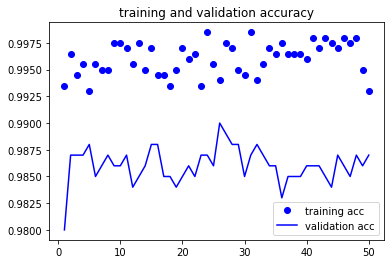

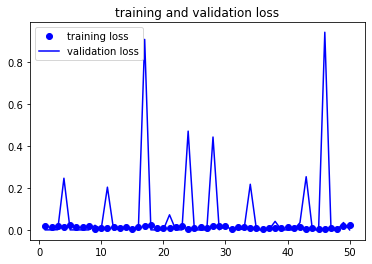

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [15]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.00221827975474298
Validation accuracy: 0.9879999756813049


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)